In [1]:
import gensim.downloader as api
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.decomposition import PCA

import numpy as np
import pickle
import json
import copy
import pandas as pd
from tqdm import tqdm
import scipy.stats as stats

from Vocab import Vocab
vocab = Vocab('data/vocab.csv', 3)
from get_predictions import get_predictions
from helpers import *

from ChainDataset import ChainDataset

chain_test_set = ChainDataset(
    data_dir='data/',
    segment_file='segments.json',
    chain_file='test_chains.json',
    vectors_file='vectors.json',
    split='test'
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lolab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initialising vocab from file.


In [2]:
import copy
import pandas as pd
import json
from tqdm import tqdm

from get_predictions import get_predictions
from ChainDataset import ChainDataset

def get_seg_ids(segment_ids_file='segment_ids_test.json'):
    # Load in the segment ids that tell us which segment belongs to which index in the history dataset
    with open(segment_ids_file) as json_file:
        segment_ids = json.load(json_file)

    return segment_ids

def create_inv_list(segment_ids):
    # Get inverted dict {seg_id:dataset_ind}
    inv_dict = {}
    for data_i in range(len(segment_ids)):
        inv_dict[segment_ids[data_i]] = data_i
    # Sort it based on segmentids
    keys = list(inv_dict)
    keys.sort()
    inv_list = [inv_dict[key] for key in keys]

    return inv_list

def reorder_datast(dataset_pred_hist, inv_list):
    # Create new history dataset with the segments in the same order as the no-history dataset
    dataset_pred_hist_cp = copy.deepcopy(dataset_pred_hist)
    # For each segment_id replace the hist_cp with the corresponding data from dataset_pred_hist
    for i in range(len(inv_list)):
        # Replace each key (cause you can't replace entire dicts here apparently...)
        for key in list(dataset_pred_hist[i]):
            dataset_pred_hist_cp[i][key] = dataset_pred_hist[inv_list[i]][key]

    return dataset_pred_hist_cp


def get_pred_dataframe(dataset_pred_no_hist, dataset_pred_hist_cp):
    """Get dataframe with the predictions per segment id of the history or no history dataset"""
    datasets = {"No history":dataset_pred_no_hist, "History": dataset_pred_hist_cp}
    dataframe = {i:{} for i in range(len(dataset_pred_no_hist))}
    print(dataset_pred_hist_cp[1]['segment'], dataset_pred_no_hist[1]['segment'])

    for data_key in datasets:
        print(data_key)
        dataset = datasets[data_key]
        # loop through all 6801 segments aka predictions
        for i in tqdm(range(len(dataset))):
            # If there is only one target and not more than 1 prediction
            if (len(dataset[i]['targets']) == 1 and
                dataset[i]['preds'].sum() <= 1):
                # If it is wrongly predicted or no image was predicted
                if dataset[i]['preds'].argmax() != dataset[i]['targets'][0] or dataset[i]['preds'].max()==0:
                    dataframe[i][data_key]=0
                # If target and prediction are the same, set prediction at 1
                else:
                    dataframe[i][data_key]=1
    return dataframe


def get_conditions_inds(dataframe):
    """Sort segment indices of the dataframe with history and no history model in the conditions"""
    # History, no history
    conditions_inds = {'hT_nhT':[], 'hT_nhF':[], 'hF_nhT':[], 'hF_nhF':[], 'only_h':[], 'only_nh':[], 'nothing':[]}
    for ind in dataframe:
        # For all indices with the same
        if 'History' in dataframe[ind] and 'No history' in dataframe[ind]:
            if dataframe[ind]['History'] == 1 and dataframe[ind]['No history'] == 1:
                conditions_inds['hT_nhT'].append(ind)

            elif dataframe[ind]['History'] == 1 and dataframe[ind]['No history'] == 0:
                conditions_inds['hT_nhF'].append(ind)

            elif dataframe[ind]['History'] == 0 and dataframe[ind]['No history'] == 1:
                conditions_inds['hF_nhT'].append(ind)

            elif dataframe[ind]['History'] == 0 and dataframe[ind]['No history'] == 0:
                conditions_inds['hF_nhF'].append(ind)

        elif 'History' in dataframe[ind]:
            conditions_inds['only_h'].append(ind)

        elif 'No history' in dataframe[ind]:
            conditions_inds['only_nh'].append(ind)
        else:
            conditions_inds['nothing'].append(ind)
    return conditions_inds


def add_chains_rounds(dataset_pred_no_hist, dataset_pred_hist_cp, chain_test_set):
    # Create empty lists for the chain ids
    for data_ind in range(len(dataset_pred_hist_cp)):
        dataset_pred_hist_cp[data_ind]['chains'] = []
        dataset_pred_hist_cp[data_ind]['chain_hist'] = []
        dataset_pred_hist_cp[data_ind]['rounds'] = []

    for data_ind in range(len(dataset_pred_no_hist)):
        dataset_pred_no_hist[data_ind]['chains'] = []
        dataset_pred_no_hist[data_ind]['chain_hist'] = []
        dataset_pred_no_hist[data_ind]['rounds'] = []

    # For each chain, add the chain index to the segment id in the dataset to which they belong
    for chain_ind in range(len(chain_test_set.chains)):
        seg_ids = chain_test_set.chains[chain_ind]['segments']
        for i in range(len(seg_ids)):
            # Add chain index
            dataset_pred_no_hist[seg_ids[i]]['chains'].append(chain_ind)
            dataset_pred_hist_cp[seg_ids[i]]['chains'].append(chain_ind)

            # Add the segment ids in the chain
            dataset_pred_no_hist[seg_ids[i]]['chain_hist'].append(chain_test_set.chains[chain_ind]['segments'])
            dataset_pred_hist_cp[seg_ids[i]]['chain_hist'].append(chain_test_set.chains[chain_ind]['segments'])

            # Add the round of the segment in the chain
            dataset_pred_no_hist[seg_ids[i]]['rounds'].append(i)
            dataset_pred_hist_cp[seg_ids[i]]['rounds'].append(i)

    return dataset_pred_no_hist, dataset_pred_hist_cp

def get_condition_seg_hist(conditions_inds, dataset_pred_hist_cp):
    condition_seg_hist = {}
    # For each condition
    for condition in conditions_inds:
        condition_seg_hist[condition] = {}
        # Iterate over the indices in this condition
        for seg_id in conditions_inds[condition]:
            condition_seg_hist[condition][seg_id] = {}
            # For each chain that this segment belongs to
            # if the segment is not the first round in that chain
            for chain_i in range(len(dataset_pred_hist_cp[seg_id]['chains'])):
                if dataset_pred_hist_cp[seg_id]['rounds'][chain_i] > 0:
                    chain_ind = dataset_pred_hist_cp[seg_id]['chains'][chain_i]
                    condition_seg_hist[condition][seg_id][chain_ind] = {}
                    # Add first segment, and segment
                    first_id = dataset_pred_hist_cp[seg_id]['chain_hist'][chain_i][0]
                    condition_seg_hist[condition][seg_id][chain_ind]['first_id'] = first_id
                    condition_seg_hist[condition][seg_id][chain_ind]['first_seg'] = dataset_pred_hist_cp[first_id]['segment']
                    condition_seg_hist[condition][seg_id][chain_ind]['current_id'] = seg_id
                    condition_seg_hist[condition][seg_id][chain_ind]['current_seg'] = dataset_pred_hist_cp[seg_id]['segment']
                    condition_seg_hist[condition][seg_id][chain_ind]['round'] = dataset_pred_hist_cp[seg_id]['rounds'][chain_i]

    return condition_seg_hist


def get_pred_datasets(split='test'):
    """
    Get the dataset of predictions for the experiment 'split'.
    Using the experiment datafiles; {split}_segments.json, {split}_segments.json
    """
    models_dict = {'History':'model_history_blind_accs_2019-02-20-14-22-23.pkl',
                'No history': 'model_blind_accs_2019-02-17-21-18-7.pkl',
                    'No image': 'model_history_noimg_accs_2019-03-01-14-25-34.pkl'}

    # Get predictions for this experiment (split) files
    dataset_pred_no_hist = get_predictions(model_name='No history', models_dict=models_dict, split=split)

    # History dataset takes about 20 minutes to run
    dataset_pred_hist = get_predictions(model_name='History', models_dict=models_dict, split=split)

    # Load in the segment ids that tell us which segment belongs to which index in the history dataset

    # Segment_ids_file segment_ids_test.json is created when predicting dataset_pred_hist
    segment_ids = get_seg_ids(segment_ids_file='segment_ids_test.json')

    # Get inverted dict {seg_id:dataset_ind}
    inv_list = create_inv_list(segment_ids)

    # Create new history dataset with the segments in the same order as the no-history dataset
    dataset_pred_hist_cp = reorder_datast(dataset_pred_hist, inv_list)

    # Add the chain indices and the round in those chains per segement
    chain_test_set = ChainDataset(
        data_dir='data/',
        segment_file='segments.json',
        chain_file='test_chains.json',
        vectors_file='vectors.json',
        split=split
    )
    dataset_pred_no_hist, dataset_pred_hist_cp = add_chains_rounds(dataset_pred_no_hist, dataset_pred_hist_cp, chain_test_set)

    dataframe = get_pred_dataframe(dataset_pred_no_hist, dataset_pred_hist_cp)
    conditions_inds = get_conditions_inds(dataframe)

    condition_seg_hist = get_condition_seg_hist(conditions_inds, dataset_pred_hist_cp)

    return dataset_pred_no_hist, dataset_pred_hist_cp, conditions_inds, condition_seg_hist


def get_accuracies(conditions_inds, dataframe):
    """Returns the accuracies per condition"""
    results_hist = {condition:[] for condition in conditions_inds}
    results_nohist = {condition:[] for condition in conditions_inds}

    # Now for all segements, also those without history (i.e. in round 1)
    # Add 1 to the condition list if it was correctly predicted, 0 if incorrect
    for condition in conditions_inds:
        for ind in conditions_inds[condition]:
            if "History" in dataframe[ind]:
                results_hist[condition].append(dataframe[ind]['History'])
            if "No history" in dataframe[ind]:
                results_nohist[condition].append(dataframe[ind]['No history'])
                
    # Get the accuracies per condition
    accs_hist = {condition:[] for condition in conditions_inds}
    accs_nohist = {condition:[] for condition in conditions_inds}
    for condition in results_hist:
        res = np.array(results_hist[condition])
        accs_hist[condition] = res.sum()/len(res)
        res = np.array(results_nohist[condition])
        accs_nohist[condition] = res.sum()/len(res)
    
    return results_hist, results_nohist, accs_hist, accs_nohist


In [3]:
wv_google_300d = api.load('word2vec-google-news-300')
wv_twitter_50d = api.load('glove-twitter-50')


## Cosine similarity

In [4]:
dataset_pred_no_hist, dataset_pred_hist_cp, conditions_inds, condition_seg_hist = get_pred_datasets()

loaded model: No history
Initialising vocab from file.
vocab len 3424
Initialising vocab from file.
Loaded seg2ranks and idlist
params. normalize=True, mask=True, weight=5.5, weighting=True, batchsize=1, breaking=False
Dataparams. data_dir=./data, segmentfile=segments.json, vectorfile=vectors.json, chains_file=chains.json
processing test

Start prediction
predict no history
{'segment': [5, 212, 4, 166, 5, 12, 22, 782, 29, 234, 213, 10, 4, 416, 14, 12, 22, 7, 6, 49, 11, 6, 155, 295, 11, 6, 811, 16, 9, 95, 10, 5, 17, 8, 12], 'image_set': ['93469', '380128', '14238', '259745', '524866', '341060', '483794', '96757'], 'targets': [5], 'length': 35, 'preds': tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]]), 'loss': tensor(4.9204), 'ranks': [0]}
getting predicitons took 56.80236005783081 seconds
loaded model: History
Initialising vocab from file.
vocab len 3424
Initialising vocab from file.
Loaded seg2ranks and idlist
par

 97%|█████████▋| 6591/6801 [00:00<00:00, 32678.49it/s]

[4, 12, 22, 7, 21, 11, 294, 16, 9, 945, 10, 5, 13, 8, 12, 31] [4, 12, 22, 7, 21, 11, 294, 16, 9, 945, 10, 5, 13, 8, 12, 31]
No history


 39%|███▉      | 2648/6801 [00:00<00:00, 26464.63it/s]

History


100%|██████████| 6801/6801 [00:00<00:00, 27495.80it/s]


In [5]:
stopword_list = stopwords.words('english')

stopword_list.append("-B-")
stopword_list.append("-A-")
stopword_list.append("<unk>")

stemmer = nltk.stem.porter.PorterStemmer()


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def embed(seg):
    embedding = np.zeros((300,))
    length = 0
    for word in seg:

        # only use word if it is not a stopword 
        if word in stopword_list:
            continue
            
        # try to embed word and add it to sentence vector 
        try:
            em = wv_google_300d[word]
            embedding += em
            length += 1
        except KeyError:
            continue
    
    return embedding / length 

# vocab.decode(condition_seg_hist['hT_nhF'][csh_keys[1]][49]['first_seg'])
def get_something(condition, condition_seg_hist):
    cosine_sim = []
    csh_keys = list(condition_seg_hist[condition])
    count = 0 
    for k in csh_keys:
        
        # ensure current chain is not empty (TODO: fix this maybe? so this doesn't happen)
        if condition_seg_hist[condition][k] == {}:
            continue
            
        # decode first and current sentence 
        first_seg = list(condition_seg_hist[condition][k].values())[0]['first_seg']
        current_seg = list(condition_seg_hist[condition][k].values())[0]['current_seg']
        dec_first_seg = vocab.decode(first_seg)
        dec_current_seg = vocab.decode(current_seg)
    
        # embed words  
        embed_first = embed(dec_first_seg).reshape(1, -1)
        embed_current = embed(dec_current_seg).reshape(1, -1)
        
        # calculate cosine similarity 
        try: 
            cosim = cosine_similarity(embed_first, embed_current)
            cosine_sim.append(cosim)
        except ValueError:
            count += 1
            
    print(count)
    
    # calculate mean and std 
    cosine_sim = np.array(cosine_sim)
    cosine_sim_mean = cosine_sim.mean()
    cosine_sim_std = cosine_sim.std()
    
    return cosine_sim_mean, cosine_sim_std

In [31]:
cosim_hT_nhF = get_something('hT_nhF', condition_seg_hist)
cosim_hT_nhT = get_something('hT_nhT', condition_seg_hist)
cosim_hF_nhF = get_something('hF_nhF', condition_seg_hist)
cosim_hF_nhT = get_something('hF_nhT', condition_seg_hist)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


3


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


7
0
0


In [33]:
stats.f_oneway(cosim_hT_nhF, cosim_hT_nhT, cosim_hF_nhF, cosim_hF_nhT)

F_onewayResult(statistic=0.0013339933011006825, pvalue=0.9999210503125144)

In [4]:
vectors = []

# incorrect_predictions['decoded_segment'], decoded

wrong_pred = incorrect_predictions['decoded_segment']
good_pred = correct_predictions['decoded_segment']

all_predictions = [good_pred, wrong_pred]


for prediction in all_predictions:

    vector = 0
    i = 0
    
    for sentence in prediction:
        for word in sentence.split(","):

            word = word.replace("'", "")
            word = word.replace(" ", "")
            word = word.lower()

    #         if word is stopword, skip the word
            if word in stopword_list:
                continue

            word = stemmer.stem(word)

            try:

                vector += wv_twitter_50d[word]
                i += 1

            except:
                None
                
    vector = vector / i
    vectors.append(vector)


print(vectors)


[array([-8.92508179e-02, -2.45265096e-01,  8.19780305e-02, -3.33554409e-02,
       -8.68604779e-02, -8.33939482e-03,  5.46882093e-01,  1.65179178e-01,
        2.08532125e-01,  3.48601133e-01, -9.33928862e-02,  1.79920807e-01,
       -3.28285956e+00,  2.69561689e-02, -1.22719491e-02,  1.84684321e-01,
        9.91539881e-02, -3.34496498e-01, -1.51952639e-01, -1.23826720e-01,
       -2.20019653e-01,  5.86802664e-04,  1.69557005e-01, -1.01809360e-01,
        1.09491479e-02,  2.17816290e-02, -1.87915027e-01, -6.05420507e-02,
        8.28245729e-02, -1.98522657e-01,  4.09429595e-02,  3.18477005e-01,
        6.46469221e-02, -3.03640574e-01,  3.02216321e-01, -2.25010961e-02,
       -9.80426744e-03,  2.73617413e-02,  6.34614006e-02, -1.49778475e-03,
       -8.75186801e-01,  9.57668126e-02, -1.70625001e-01,  1.03947945e-01,
        2.70428836e-01, -1.31704006e-02,  3.16535622e-01,  3.77877802e-02,
       -8.66262801e-03,  2.58087534e-02], dtype=float32), array([-7.83506781e-02, -2.46343359e-01, 

## POS tags distribution


In [111]:
from collections import Counter
import nltk
import pickle
from nltk import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')

import matplotlib
import matplotlib.pyplot as plt

with open('oov_dictionary.pickle', 'rb') as f:
    oov_dict = pickle.load(f)

top_10 = ['NOUN', 'DET', 'VERB', 'ADP', 'ADJ', '.', 'ADV', 'NUM', 'PRON', 'CONJ']
top_4 = ['NOUN', 'VERB', 'ADJ', 'ADV']

''' explanation:

ADJ	adjective	new, good, high, special, big, local
ADP	adposition	on, of, at, with, by, into, under
ADV	adverb	really, already, still, early, now
CONJ	conjunction	and, or, but, if, while, although
DET	determiner, article	the, a, some, most, every, no, which
NOUN	noun	year, home, costs, time, Africa
NUM	numeral	twenty-four, fourth, 1991, 14:24
PRT	particle	at, on, out, over per, that, up, with
PRON	pronoun	he, their, her, its, my, I, us
VERB	verb	is, say, told, given, playing, would
.	punctuation marks	. , ; !
X	other	ersatz, esprit, dunno, gr8, univeristy

'''

oov_dict



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lolab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lolab\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\lolab\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\lolab\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


{'grey': 'gray',
 'ok.': 'OK',
 't-shirt': 'tshirt',
 'w/': 'with',
 'frige': 'fridge',
 'red/white': 'red and white',
 'doughnuts': 'donuts',
 'didnt': "didn't",
 'ok..': 'ok',
 'dr.': 'dr',
 'no..': 'no',
 'doughnut': 'donut',
 'yes..': 'yes',
 'yellow/orange': 'yellow and orange',
 'pic..': 'picture',
 'umberlla': 'umbrella',
 'cest': 'chest',
 'k..next': 'ok, next',
 'surboard': 'surfboard',
 'blue/white': 'blue and white',
 'man/woman': 'man or woman',
 'doesnt': "doesn't",
 'scheppa': 'schepps',
 'guy/girl': 'guy or girl',
 'blue/green': 'blue and green',
 'schepp': 'schepps',
 'blue/black': 'blue and black',
 'motarcycle': 'motorcycle',
 'red/black': 'red and black',
 'red/white/blue': 'red, white and blue',
 'colour': 'color',
 'close-up': 'closeup',
 'green/yellow': 'green and yellow',
 'red/pink': 'red and pink',
 'buddist': 'buddhist',
 'longsleeves': 'long sleeves',
 'ihave': 'i have',
 'yellow/green': 'yellow and green',
 'no-': 'no',
 'k.': 'ok',
 'surfobard': 'surfboard'

In [4]:
dataset_pred_no_hist, dataset_pred_hist_cp, conditions_inds, condition_seg_hist = get_pred_datasets()



loaded model: No history
Initialising vocab from file.
vocab len 3424
Initialising vocab from file.
Loaded seg2ranks and idlist
params. normalize=True, mask=True, weight=5.5, weighting=True, batchsize=1, breaking=False
Dataparams. data_dir=./data, segmentfile=segments.json, vectorfile=vectors.json, chains_file=chains.json
segment dataset with segments.json vectors.json test
history dataset with test_segments.json vectors.json test_chains.json test
processing test

Start prediction
predict no history
{'segment': [5, 212, 4, 166, 5, 12, 22, 782, 29, 234, 213, 10, 4, 416, 14, 12, 22, 7, 6, 49, 11, 6, 155, 295, 11, 6, 811, 16, 9, 95, 10, 5, 17, 8, 12], 'image_set': ['93469', '380128', '14238', '259745', '524866', '341060', '483794', '96757'], 'targets': [5], 'length': 35, 'preds': tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0'), 'loss': tensor(4.9204, device='cuda:0'), 'ranks': [0]}
getting predicito

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6801/6801 [00:01<00:00, 4267.32it/s]


History


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6801/6801 [00:01<00:00, 4410.85it/s]


NameError: name 'dataset_pred' is not defined

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 744.31it/s]


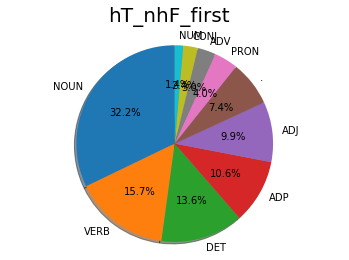

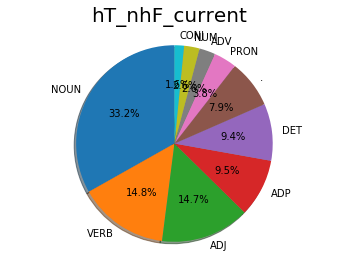

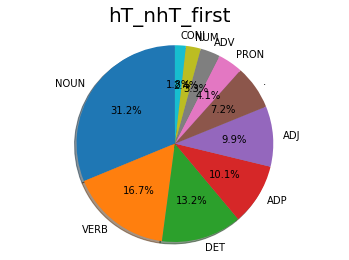

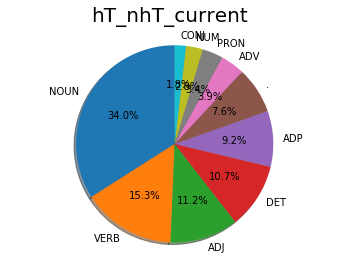

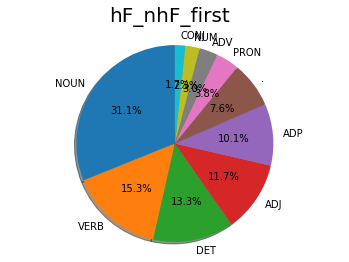

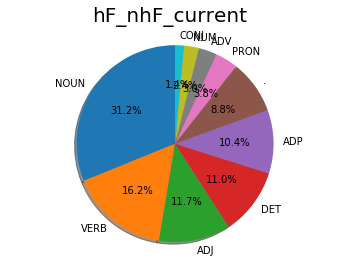

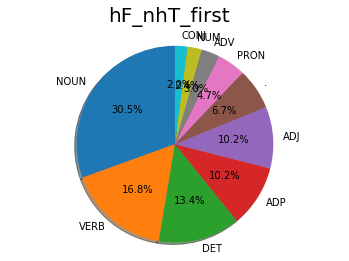

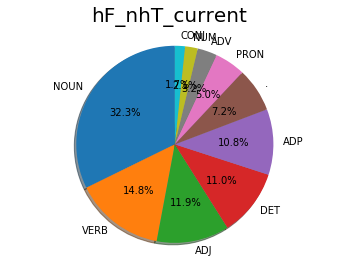

In [196]:
def pos_tag_distribution_per_group(group):
    segments = list(condition_seg_hist[group])
    for segment in tqdm(segments):
        if condition_seg_hist[group][segment] == {}:
                continue

    #   get sentences per segment
        first_seg, current_seg = convert_to_sentences(segment, condition_seg_hist[group])
        first_sentence_dict = sentence_to_pos_tags(first_seg)
        current_sentence_dict = sentence_to_pos_tags(current_seg)

    #   update dicts
        update_dict(first_sentence_dict, total_first_seg_dict)
        update_dict(current_sentence_dict, total_current_dict)

    return total_first_seg_dict, total_current_dict


def convert_to_sentences(segment, dataset):
          
    # decode first and current sentence 
    first_seg = list(dataset[segment].values())[0]['first_seg']

    current_seg = list(dataset[segment].values())[0]['current_seg']
    dec_first_seg = vocab.decode(first_seg)
    dec_current_seg = vocab.decode(current_seg)
    
    return dec_first_seg, dec_current_seg



def update_dict(new_dict, total_dict):
    for key, value in new_dict.items():
        new_key = key
        new_value = value
#         print("new key", new_key)
#         print("new_value", new_value)
        for key, value in total_dict.items():
            if key == new_key:
                current_value = total_dict[key] 
                update_value = current_value + new_value[0]
                total_dict[key] = update_value
                
    return None

def dict_to_result(first_seg_dict, group, result, place): #   convert dict to list
    
    dict_list = []
    total = 0
    for key, value in first_seg_dict.items():
        temp = [value,key]
        total += value
        dict_list.append(temp)
    
#   convert to percentages
    for tag in dict_list:
        tag[0] = tag[0] / total
    
    dict_list.sort(reverse = True)
    group = group + "_" +  place
    
    result[group] = dict_list
    
    return result

    


groups = ['hT_nhF', 'hT_nhT', 'hF_nhF','hF_nhT']
# groups = ['hT_nhF', 'hF_nhF']
result = {}
for group in groups:
    
    total_first_seg_dict = {
    'NOUN': 0,
    'DET': 0,
    'VERB': 0,
    'ADP': 0,
    'ADJ': 0,
    '.': 0,
    'ADV': 0,
    'NUM': 0,
    'PRON': 0,
    'CONJ': 0
                            }

    total_current_dict = {
        'NOUN': 0,
        'DET': 0,
        'VERB': 0,
        'ADP': 0,
        'ADJ': 0,
        '.': 0,
        'ADV': 0,
        'NUM': 0,
        'PRON': 0,
        'CONJ': 0
                        }
    
    total_first_seg_dict, total_current_dict = pos_tag_distribution_per_group(group)
    result = dict_to_result(total_first_seg_dict, group, result, "first")
    result = dict_to_result(total_current_dict, group, result, "current")
    
# print(result)
for key, value in result.items():
    plot_dict(key, value)



    
    


In [190]:
# dicti = {'hT_nhF': [[0.32154088050314467, 'NOUN'], [0.15683962264150944, 'VERB'], [0.13561320754716982, 'DET'], [0.10573899371069183, 'ADP'], [0.09905660377358491, 'ADJ'], [0.07389937106918239, '.'], [0.03970125786163522, 'PRON'], [0.029874213836477988, 'ADV'], [0.02397798742138365, 'CONJ'], [0.013757861635220126, 'NUM']]}

# dicti
def plot_dict(plot_title, values):
    labels = []
    all_values = []

#     print("values", values)
#     print(len(values))
    for v in range(len(values)):
#         print("v", values[v])

        labels.append(values[v][1])
        all_values.append(values[v][0])
#     print("KLAAAR")
    
#     print()



    fig1, ax1 = plt.subplots()
    ax1.pie(all_values, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    fig1.suptitle(plot_title, fontsize=20)
    plt.show()



In [67]:
# text = " Guru99 is one of the best sites to learn WEB, SAP, Ethical Hacking and much more online."
messages = ['ik ben bob en daar is het strand maar toen zei hij']



def sentence_to_pos_tags(sentence):
    
    lower_case_sentence = []
    correct_sentence = [] 
    pos_tags = []
    

    for word in sentence:
        lower_case_sentence.append(word.lower())
    

    for word in lower_case_sentence:

        if word not in oov_dict:
            correct_sentence.append(word)
        else:
            correct_sentence.append(oov_dict[word])

#   tag the sentence
    try:
        pos_tags += [word[1] for word in pos_tag(correct_sentence, tagset='universal')]
#         print("mistake")
    except:
        None

        
    pos_tag_dict = dict()       
    for key,value in dict(Counter(pos_tags)).items():
        pos_tag_dict[key] = [value]  

    return pos_tag_dict


In [55]:
test_dict = {
    'NOUN': 0,
    'DET': 0,
    'VERB': 0,
    'ADP': 0,
    'ADJ': 0,
    '.': 0,
    'ADV': 0,
    'NUM': 0,
    'PRON': 0,
    'CONJ': 0
}

new_dict = {
    'NOUN': 5,
    'ADV': 20,
}

for key, value in new_dict.items():
    new_key = key
    new_value = value
    print("new key", new_key)
    print("new_value", new_value)
    for key, value in test_dict.items():
        if key == new_key:
            print("found", key)
            test_dict[key] += new_value
            
print(test_dict)

new key NOUN
new_value 5
found NOUN
new key ADV
new_value 20
found ADV
{'NOUN': 5, 'DET': 0, 'VERB': 0, 'ADP': 0, 'ADJ': 0, '.': 0, 'ADV': 20, 'NUM': 0, 'PRON': 0, 'CONJ': 0}


In [174]:
values = [[0.32154088050314467, 'NOUN'], [0.15683962264150944, 'VERB'], [0.13561320754716982, 'DET'], [0.10573899371069183, 'ADP'], [0.09905660377358491, 'ADJ'], [0.07389937106918239, '.'], [0.03970125786163522, 'PRON'], [0.029874213836477988, 'ADV'], [0.02397798742138365, 'CONJ'], [0.013757861635220126, 'NUM']]

for v in values:
    print(v)

[0.32154088050314467, 'NOUN']
[0.15683962264150944, 'VERB']
[0.13561320754716982, 'DET']
[0.10573899371069183, 'ADP']
[0.09905660377358491, 'ADJ']
[0.07389937106918239, '.']
[0.03970125786163522, 'PRON']
[0.029874213836477988, 'ADV']
[0.02397798742138365, 'CONJ']
[0.013757861635220126, 'NUM']
